In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import metrics
import mlflow
from keras.models import Sequential
import tensorflow as tf
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

2022-10-20 09:47:17.698781: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data = pd.read_csv("../Data/cleaned_5310.csv")

In [3]:
df = data.copy()
df = df[['Period','Value']]
s1 = df.shape[0]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30318 entries, 0 to 30317
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Period  30318 non-null  object 
 1   Value   30318 non-null  float64
dtypes: float64(1), object(1)
memory usage: 473.8+ KB


In [5]:
df['Period'] = pd.to_datetime(df['Period'],format="%Y-%m-%d")

/var/folders/0z/5dyhp7xx5g700b6sqbzkl_fw0000gn/T/ipykernel_25413/2939504845.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  bar.set_xticklabels(bar.get_xticklabels(),rotation=60)


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

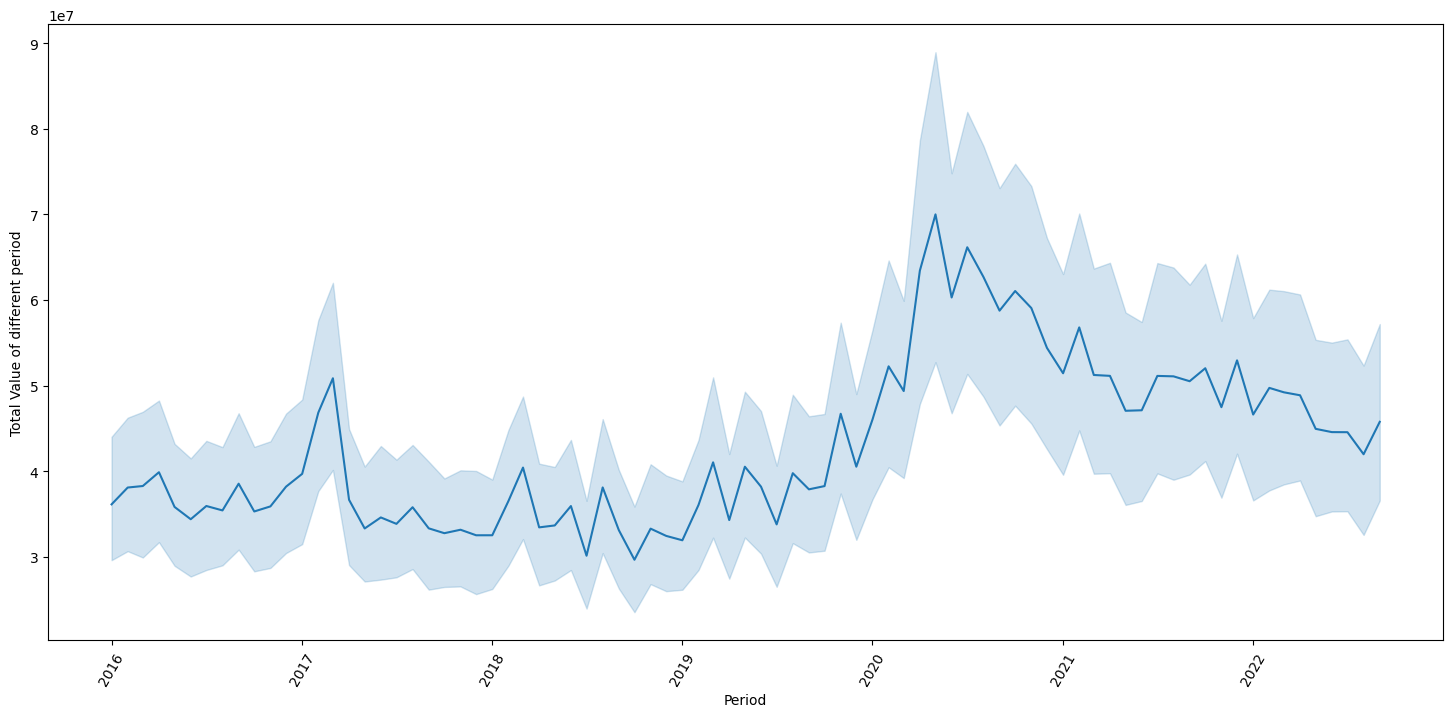

In [6]:
plt.figure(figsize=(18,8))
bar = sns.lineplot(x='Period',y='Value',data= df)
bar.set_xticklabels(bar.get_xticklabels(),rotation=60)
plt.ylabel('Total Value of different period')
plt.tight_layout

/var/folders/0z/5dyhp7xx5g700b6sqbzkl_fw0000gn/T/ipykernel_25413/4051625520.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Value'])


<AxesSubplot: xlabel='Value', ylabel='Density'>

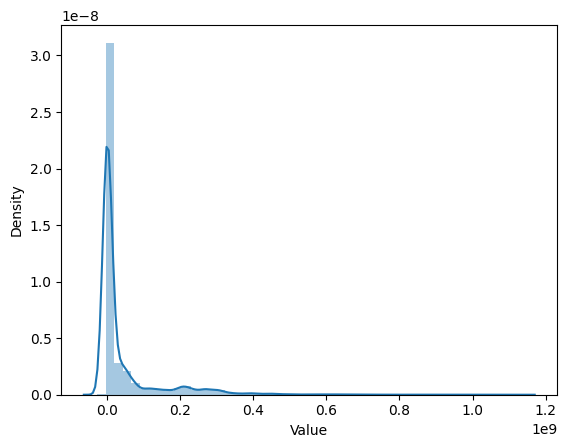

In [7]:
# distribution of value
sns.distplot(df['Value'])

/Users/michael/opt/anaconda3/envs/anomaly/lib/python3.9/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/0z/5dyhp7xx5g700b6sqbzkl_fw0000gn/T/ipykernel_25413/3073923751.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(df['Value']))


<AxesSubplot: xlabel='Value', ylabel='Density'>

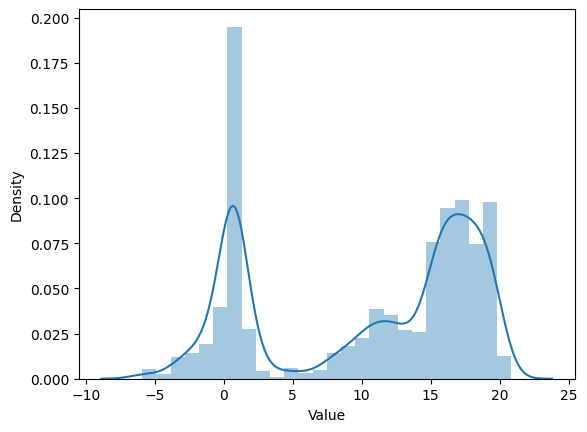

In [8]:
sns.distplot(np.log(df['Value']))

The range of the value is big, therefore, it is better to scale the data.
Data 

In [9]:
df['log_value'] = np.log(df['Value'])

/Users/michael/opt/anaconda3/envs/anomaly/lib/python3.9/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [10]:
df.head()

,Period,Value,log_value
0,2022-09-01,22361.0,10.015074
1,2022-09-01,598797.0,13.302678
2,2022-09-01,111845.0,11.624869
3,2022-09-01,327770.0,12.700067
4,2022-09-01,15163.0,9.626614


In [11]:
df.dropna(axis=0, inplace=True)
s2 = df.shape[0]
print("df shape", df.shape)
print("Total dropped rows: ", s2-s1)

df shape (29796, 3)
Total dropped rows:  -522


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29796 entries, 0 to 30317
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Period     29796 non-null  datetime64[ns]
 1   Value      29796 non-null  float64       
 2   log_value  29796 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 931.1 KB


## preprocessing the data, split to train and test with sklearn

In [13]:
from random import random
from sklearn.model_selection import train_test_split
scaler = preprocessing.MinMaxScaler()
def prepare_data(df,forecast_col, forecast_len, test_size):
    label = df[forecast_col].shift(-forecast_len)
    X = np.array(df[[forecast_col]])
    X_recent = X[-forecast_len:]
    X = X[:-forecast_len]
    label.dropna(inplace=True)
    y = np.array(label)
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)
    
    #y_train = scaler.fit_transform(y_train)
    #y_test = scaler.fit_transform(y_test)
    print("shape of X_train, test", X_train.shape, X_test.shape )
    response = [X_train, X_test, y_train, y_test, X_recent]
    return response

In [14]:
test_size = 0.2
forecast_col = 'log_value'
forecast_len = 100
X_train, X_test, y_train, y_test,X_recent= prepare_data(df, forecast_col,forecast_len,test_size)


shape of X_train, test (23756, 1) (5940, 1)


In [15]:
X_train

array([[14.21106067],
       [ 0.69314718],
       [19.14247716],
       ...,
       [ 2.30258509],
       [-2.31263543],
       [ 9.97780622]])

/var/folders/0z/5dyhp7xx5g700b6sqbzkl_fw0000gn/T/ipykernel_25413/471094998.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  bar.set_xticklabels(bar.get_xticklabels(),rotation=60)


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

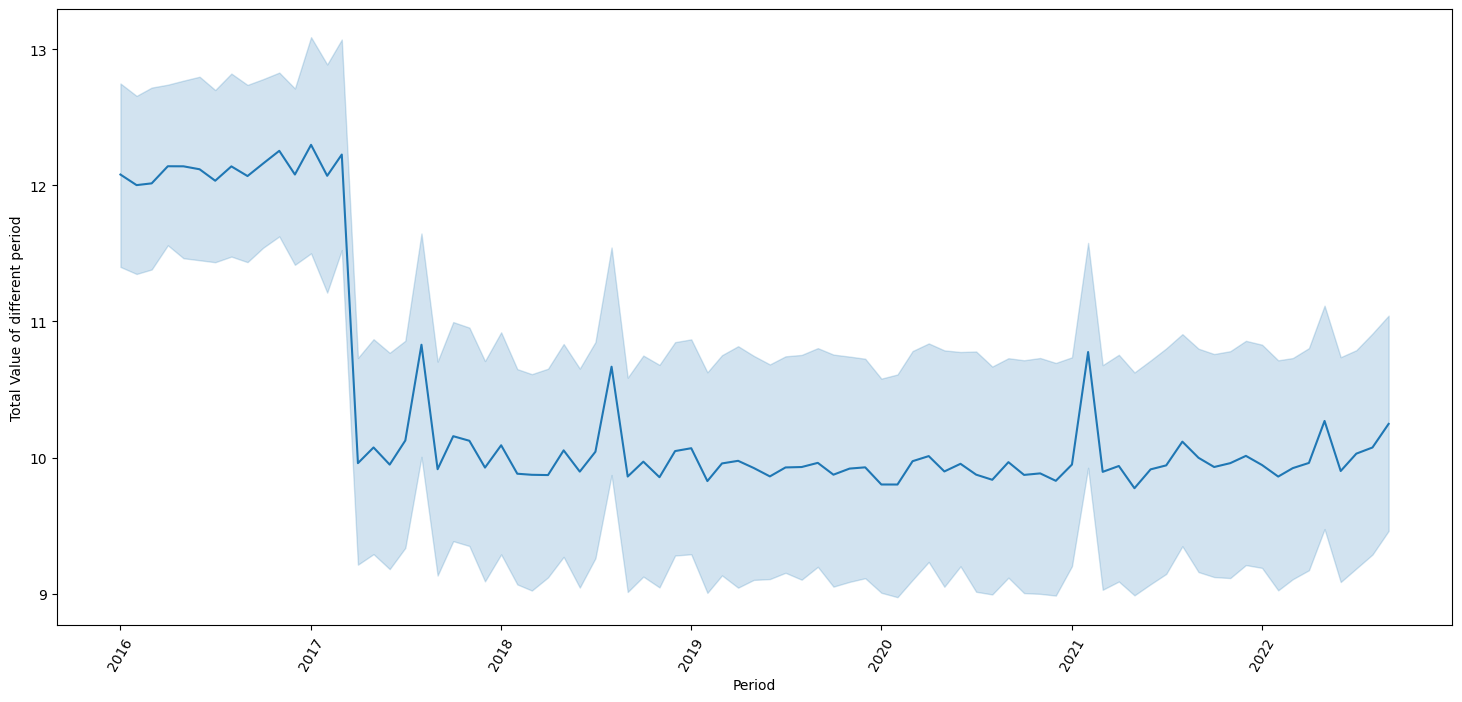

In [16]:
plt.figure(figsize=(18,8))
bar = sns.lineplot(x='Period',y='log_value',data= df)
bar.set_xticklabels(bar.get_xticklabels(),rotation=60)
plt.ylabel('Total Value of different period')
plt.tight_layout

### 1. Explore the data with linear regression model

In [17]:

def plot(X_test,y_test,forecast,title='model'):
    fig = plt.figure(figsize=(20,10))
    ax = plt.subplot(111)
    ax.scatter(X_test,y_test,label='Actual')
    ax.scatter(X_test,forecast,label='Predict')
    plt.title('model')
    ax.legend()

def lineplot(df, x_name = 'Period',y_name= 'Value'):
    plt.figure(figsize=(18,8))
    bar = sns.lineplot(x=x_name,y=y_name,data= df)
    bar.set_xticklabels(bar.get_xticklabels(),rotation=60)
    plt.ylabel('Total Value of different period')
    plt.tight_layout

def print_metrics(y_test,y_pred):
    print("Mean square error is ", metrics.mean_squared_error(y_test,y_pred))

X train and test data shape (23756, 1) (23756,)
Mean square error is  50.98051613698914
score is  -0.00011112173476979237


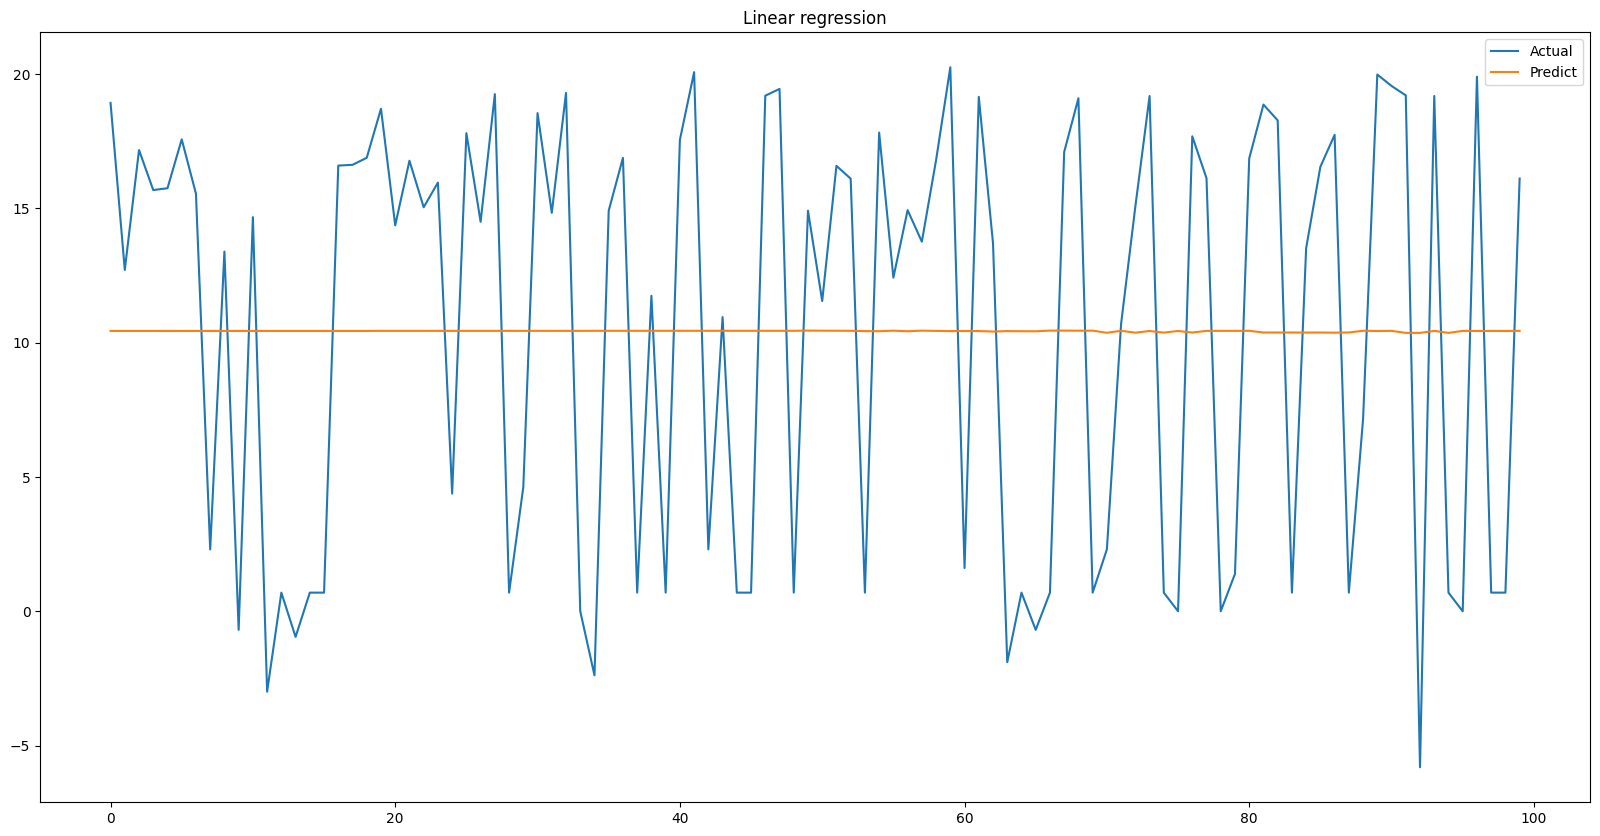

In [18]:
lm = linear_model.LinearRegression()
print("X train and test data shape", X_train.shape, y_train.shape)
lm.fit(X_train,y_train)
forecast = lm.predict(X_recent)
print_metrics(X_recent,forecast)
print("score is ",lm.score(X_test,y_test))
fig = plt.figure(figsize=(20,10))
ax = plt.subplot(111)
ax.plot(y_test[:forecast_len],label='Actual')
ax.plot(forecast,label='Predict')
plt.title('Linear regression')
ax.legend()

Apparently, the linear regression model doesn't provide a good fit for the data.

### Moving average
* Simple moving average: df.rolling(). Aggregate certain window size of data for their mean value.
* 

In [19]:
# aggregate data according to the period
df2 = df.groupby('Period')['Value'].sum().rename('Total_value').reset_index()
df2.sort_values(by='Period',ascending=True, inplace=True)

In [20]:
print("shape of the data after aggregation: ", df2.shape)

shape of the data after aggregation:  (81, 2)


In [25]:
ma_window = 3
df_pred = df2.copy()
train_len = 65
df_pred['sma_forecast'] = df_pred['Total_value'].rolling(ma_window).mean()
df_pred['sma_forecast'][train_len:] = df_pred['sma_forecast'][train_len-1]

/var/folders/0z/5dyhp7xx5g700b6sqbzkl_fw0000gn/T/ipykernel_25413/2805750278.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['sma_forecast'][train_len:] = df_pred['sma_forecast'][train_len-1]


In [26]:
train = df2[0:train_len]
test = df2[train_len:]

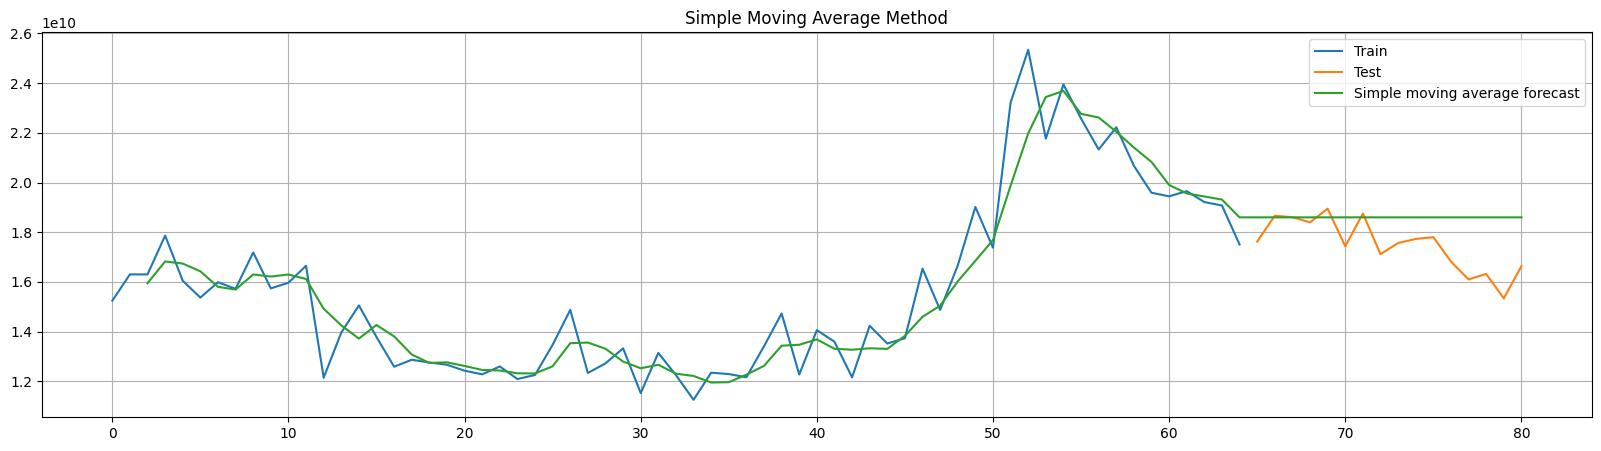

In [27]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(train['Total_value'], label='Train')
plt.plot(test['Total_value'], label='Test')
plt.plot(df_pred['sma_forecast'], label='Simple moving average forecast')
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

In [32]:
test['Total_value']

65    1.762331e+10
66    1.866598e+10
67    1.860425e+10
68    1.839650e+10
69    1.894784e+10
70    1.743382e+10
71    1.875390e+10
72    1.711758e+10
73    1.756389e+10
74    1.772980e+10
75    1.780113e+10
76    1.682249e+10
77    1.610090e+10
78    1.632039e+10
79    1.533539e+10
80    1.663189e+10
Name: Total_value, dtype: float64

In [33]:
df_pred['sma_forecast'][train_len:]

65    1.859892e+10
66    1.859892e+10
67    1.859892e+10
68    1.859892e+10
69    1.859892e+10
70    1.859892e+10
71    1.859892e+10
72    1.859892e+10
73    1.859892e+10
74    1.859892e+10
75    1.859892e+10
76    1.859892e+10
77    1.859892e+10
78    1.859892e+10
79    1.859892e+10
80    1.859892e+10
Name: sma_forecast, dtype: float64

In [35]:
residue = test['Total_value']- df_pred['sma_forecast'][train_len:]

In [28]:
# Metrics, RMSE (Root-mean-square error/deviation), MAPE (mean absolute percentage error)
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Total_value'], df_pred['sma_forecast'][train_len:])).round(2)
mape = np.round(np.mean(np.abs(test['Total_value']-df_pred['sma_forecast'][train_len:])/test['Total_value'])*100,2)

results = pd.DataFrame({'Method':['Simple moving average forecast'], 'MAPE': [mape], 'RMSE': [rmse]})
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Simple moving average forecast,1.505520e+09,7.09


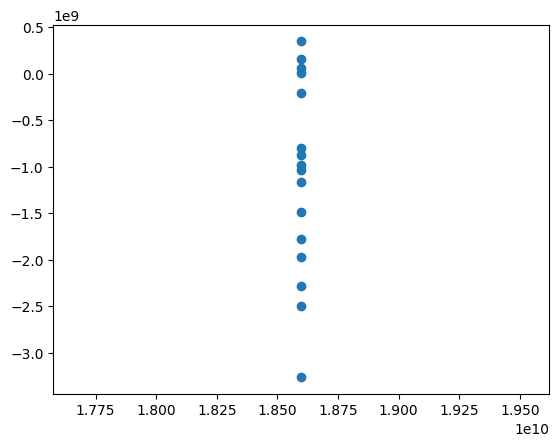

In [36]:
# visulize residue to assess the model
plt.scatter(x =df_pred['sma_forecast'][train_len:],y=residue )

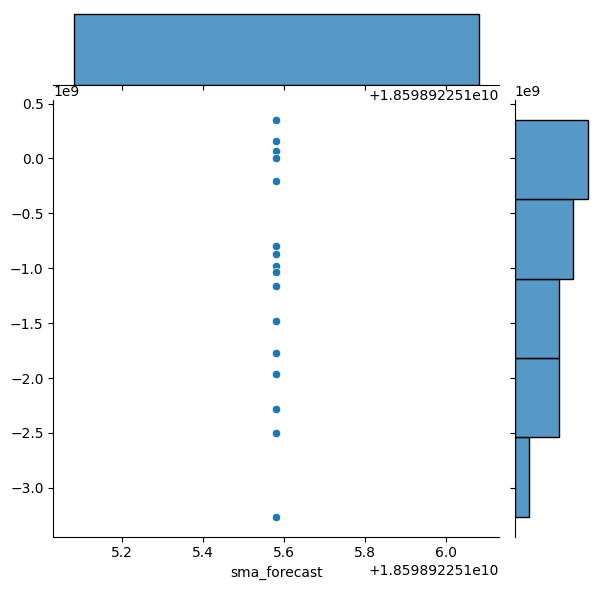

In [37]:
sns.jointplot(x =df_pred['sma_forecast'][train_len:],y=residue)

With the window size of 5, moving average follows the trend of the total_value in 81 period. Residue plots and RMSE value indicate huge errors for this model.

### classical exponential smoothing methods

### ARIMA model selection methods